# AE 352 Final Project - Hover and Circle Path

In [2]:
# Import all necessary packages
import ae352_quadrotor

import sympy as sym
import numpy as np
from scipy import signal
from scipy import linalg
import matplotlib.pyplot as plt
sym.init_printing()

pybullet build time: Feb  5 2024 14:05:35


In [3]:
grav = 9.81

The following code blocks were given by the project template code from DP 4: Designing a Controller for Drone Racing to derive the equations of motion for the spacecraft, $f$, and the sensor model, $g$.

For a more comprehensive overview of the derivations, the source code is linked [here](https://github.com/w-chang/ae353-sp24/blob/main/Projects/04_Quadrotor/ae353_quadrotor-EoM.ipynb).

In [4]:
# Define mass and moment of inertia of the bus
mass = 0.7185    # in kilograms
Ixx = 0.002470  # in kilograms
Iyy = 0.001050  # in kilograms
Izz = 0.002403  # in kilograms
lxy = 0.25    # x/y distance from the quadrotor frame to the mocap markers (m)
lz = 0.046875 # z distance from the quadrotor frame to the mocap markers (m)

px_inW, py_inW, pz_inW = sym.symbols('p_x, p_y, p_z')
p_inW = sym.Matrix([[px_inW],
                    [py_inW],
                    [pz_inW]])

vx_inB, vy_inB, vz_inB = sym.symbols('v_x, v_y, v_z')
v_inB = sym.Matrix([[vx_inB],
                    [vy_inB],
                    [vz_inB]])

phi, theta, psi = sym.symbols('phi, theta, psi')

wx_inB, wy_inB, wz_inB = sym.symbols('omega_x, omega_y, omega_z')
w_inB = sym.Matrix([[wx_inB],
                    [wy_inB],
                    [wz_inB]])

Rx = sym.Matrix([[1,            0,             0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi),  sym.cos(phi)]])
Ry = sym.Matrix([[ sym.cos(theta), 0, sym.sin(theta)],
                 [              0, 1,              0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi),  sym.cos(psi), 0],
                 [           0,             0, 1]])
R_ofB_inW = Rz @ Ry @ Rx
R_ofW_inB = R_ofB_inW.T

# Define inputs
taux_inB, tauy_inB, tauz_inB, fz_inB = sym.symbols('tau_x, tau_y, tau_z, f_z')

# Get the net torque vector
tau_inB = sym.Matrix([[taux_inB],
                      [tauy_inB],
                      [tauz_inB]])
tau_inB = sym.simplify(tau_inB)

# Get the gravity force and convert to body coordiantes
grav_inW = sym.Matrix([[0.],
                       [0.],
                       [-mass * grav]])
grav_inB = R_ofW_inB @ grav_inW

# Get the net force vector
f_inB = grav_inB + sym.Matrix([[0.],
                               [0.],
                               [fz_inB]])
f_inB = sym.simplify(f_inB)

I_inB = sym.Matrix([[Ixx, 0.,  0.],
                    [0.,  Iyy, 0.],
                    [0.,  0.,  Izz]])

v_inW = R_ofB_inW @ v_inB
xyz_dot = sym.simplify(v_inW)

v_inB_dot = (1 / mass) * (f_inB - w_inB.cross(mass * v_inB))
v_inB_dot = sym.simplify(v_inB_dot)

ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.Matrix.hstack(ex, Rx.T@ey, (Ry@Rx).T@ez)

M_inv = sym.simplify(M.inv())

rpy_dot = sym.simplify(M_inv@w_inB)

w_inB_dot = I_inB.inv() @ (tau_inB - w_inB.cross(I_inB@w_inB))
w_inB_dot = sym.simplify(w_inB_dot)

Here, we assemble the equations of motion into one system of first order differential equations where $f$ is our system model such that
$$\begin{bmatrix} \dot{p_x} \\ \dot{p_y} \\ \dot{p_z} \\ \dot{v_x} \\ \dot{v_y} \\ \dot{v_z} \\ \dot{\phi} \\ \dot{\theta} \\ \dot{\psi} \\ \dot{\omega_x} \\ \dot{\omega_y} \\ \dot{\omega_z} \end{bmatrix}=f\left(p_x, p_y, p_z, v_x, v_y, v_z, \phi, \theta, \psi, \omega_x, \omega_y, \omega_z, \tau_x, \tau_y, \tau_z, f_z\right)$$

In [5]:
f = sym.Matrix.vstack(xyz_dot,
                      v_inB_dot,
                      rpy_dot,
                      w_inB_dot)

## System Linearization and State Space Form

In [6]:
m = [px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB]
n = [taux_inB, tauy_inB, tauz_inB, fz_inB]

px_inW_e, py_inW_e, pz_inW_e = 0.0, 0.0, 0.0
vx_inB_e, vy_inB_e, vz_inB_e = 0.0, 0.0, 0.0
phi_e, theta_e, psi_e = 0.0, 0.0, 0.0
wx_inB_e, wy_inB_e, wz_inB_e = 0.0, 0.0, 0.0

taux_inB_e, tauy_inB_e, tauz_inB_e, fz_inB_e = 0.0, 0.0, 0.0, 9.81*mass

A_num = sym.lambdify((px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB, taux_inB, tauy_inB, tauz_inB, fz_inB), f.jacobian(m))
A = A_num(px_inW_e, py_inW_e, pz_inW_e, vx_inB_e, vy_inB_e, vz_inB_e, phi_e, theta_e, psi_e, wx_inB_e, wy_inB_e, wz_inB_e, taux_inB_e, tauy_inB_e, tauz_inB_e, fz_inB_e)

B_num = sym.lambdify((px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, phi, theta, psi, wx_inB, wy_inB, wz_inB, taux_inB, tauy_inB, tauz_inB, fz_inB), f.jacobian(n))
B = B_num(px_inW_e, py_inW_e, pz_inW_e, vx_inB_e, vy_inB_e, vz_inB_e, phi_e, theta_e, psi_e, wx_inB_e, wy_inB_e, wz_inB_e, taux_inB_e, tauy_inB_e, tauz_inB_e, fz_inB_e)

## Determining Controllability

In [7]:
# Checking for controllability

def controllability(A, B):
    Wc = B
    for i in range(1, A.shape[0]):
        col = np.linalg.matrix_power(A, i) @ B
        Wc = np.block([Wc, col])
        
    rank_Wc = np.linalg.matrix_rank(Wc)
    return np.allclose(rank_Wc, A.shape[0])
    
print("Controllability:", controllability(A, B))

Controllability: True


## Gain Selection and Controller/Observor Design

In [8]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @ B.T @ P
    return K, P

# uses Bryson's Rule
Qc= np.diag([1/50**2, 1/50**2, 1/10**2, 1/100**2, 1/100**2, 1/100**2, 1/50**2, 1/100**2, 1/100**2, 1/40**2, 1/40**2, 1/40**2])
Rc = np.diag([1/0.3**2, 1/0.3**2, 1/0.3**2, 1/15**2])

# get gain matrix K
K, P = lqr(A, B, Qc, Rc)


# Test system stability
def stability(K):
    F = A - B@K
    return (linalg.eigvals(F).real < 0).all()

print("Stability:", stability(K))

Stability: True


## Performance Goal Paths

In [9]:
# 1. Hover 1m above ground for 2 minutes.
def hover_path(dt):
    return [[0, 0, 1] for _ in range(int(120/dt))]

# 2. Fly in a circle of radius 2m, at an altitude of 1m above ground at a speed of 0.5m/s for at least 1 minute.
import numpy as np

def circle_path(radius, altitude, speed , total_time, dt):

    # Angular velocity for a constant speed along the circle
    circumference = 2 * np.pi * radius
    angular_velocity = 0.5 / radius  # rad/s
    total_angle = angular_velocity * total_time  # Total angle to cover

    # Time vector
    t = np.arange(0, total_time, dt)
    angles = angular_velocity * t  # Compute the angle at each time step

    # Circular path equations
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    z = np.full_like(angles, altitude)  # Altitude remains constant

    return np.vstack((x, y, z)).T

In [10]:
# Create the Controller class
class Controller():
    def __init__(self, goal_path):
        """
        Initializes the controller. You should initialize any member variables that
        the controller will use to their starting values. This function is called
        when a new instance of the Controller class is created.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        # define matrices for state space form with output
        self.A = A
        self.B = B
        # define gain matrices
        self.K = K
        # define desired equilibrium position
        self.px_inW_e = px_inW_e
        self.py_inW_e = py_inW_e
        self.pz_inW_e = pz_inW_e
        self.vx_inB_e = vx_inB_e
        self.vy_inB_e = vy_inB_e
        self.vz_inB_e = vz_inB_e
        self.phi_e = phi_e
        self.theta_e = theta_e
        self.psi_e = psi_e
        self.wx_inB_e = wx_inB_e
        self.wy_inB_e = wy_inB_e
        self.wz_inB_e = wz_inB_e

        self.taux_inB_e = taux_inB_e
        self.tauy_inB_e = tauy_inB_e
        self.tauz_inB_e = tauz_inB_e
        self.fz_inB_e = fz_inB_e

        self.goal_path = goal_path
        self.current_point = 0
        self.num_points = len(goal_path)

        # Create variable to keeps track of all previous xhat data
        self.xhat_history = {"px" : [],
                            "py" : [],
                            "pz" : [],
                            "vx" : [],
                            "vy" : [],
                            "vz" : [],
                            "phi" : [],
                            "theta": [],
                            "psi" : [],
                            "wx" : [],
                            "wy" : [],
                            "wz" : []}

    
    def reset(self):
        """
        Resets the controller to an initial state. You should reset any variables
        that track states, times, etc. in this function. This function will be 
        called just before the simulation starts running and any time the simulation
        is reset.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        self.xhat = np.zeros(12)
        self.current_point = 0
        
        # Reset the variable keeping track of xhat data
        self.xhat_history = {"px" : [],
                            "py" : [],
                            "pz" : [],
                            "vx" : [],
                            "vy" : [],
                            "vz" : [],
                            "phi" : [],
                            "theta": [],
                            "psi" : [],
                            "wx" : [],
                            "wy" : [],
                            "wz" : []}
    
    
    def run(self, **kwargs):
        """
        Runs the controller. Data is passed from the simulation environment to the
        controller via kwargs, the controller calculates the inputs to the system,
        and then returns them via a return statement
    
        Parameters
        ----------
        **kwargs : Dictionary
            A dictionary of data passed from the simulation environment to the 
            controller. Specific data is extracted from kwargs via the statement:
            kwargs["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys
            of kwargs for this project are as follows:

            kwargs["dt"] : float
                The simulation time step in seconds.

            kwargs["time"] : float
                The current simulation time in seconds.
    
        Returns
        -------
        inputs : List with length equal to the number of inputs
            This is a list of the inputs calculated by the controller. In this
            project, there are four inputs, tau_x, tau_y, tau_z, f_z.
            Therefore, inputs has the form:
            inputs = [tau_x, tau_y, tau_z, f_z]
        
        """
        # if finished performance goal, stop
        if self.current_point >= self.num_points:
            return [0, 0, 0, 0] 
        
        self.dt = kwargs["dt"] 
        self.p_hat = self.xhat[:3]
        self.p_goal = self.goal_path[self.current_point]
        
        self.x_des = np.hstack((self.p_goal, np.zeros(9)))

        u = -self.K @ (self.xhat - self.x_des)
        inputs = u + np.array([self.taux_inB_e, self.tauy_inB_e, self.tauz_inB_e, self.fz_inB_e])

        self.current_point += 1

        self.xhat += self.dt * (self.A@self.xhat + self.B@u)

        # Store the current xhat
        self.xhat_history["px"].append(self.xhat[0])
        self.xhat_history["py"].append(self.xhat[1])
        self.xhat_history["pz"].append(self.xhat[2])
        self.xhat_history["vx"].append(self.xhat[3])
        self.xhat_history["vy"].append(self.xhat[4])
        self.xhat_history["vz"].append(self.xhat[5])
        self.xhat_history["phi"].append(self.xhat[6])
        self.xhat_history["theta"].append(self.xhat[7])
        self.xhat_history["psi"].append(self.xhat[8])
        self.xhat_history["wx"].append(self.xhat[9])
        self.xhat_history["wy"].append(self.xhat[10])
        self.xhat_history["wz"].append(self.xhat[11])
        
        return inputs

# Post-processing the simulation data

## Performance Goal 1: Hovering

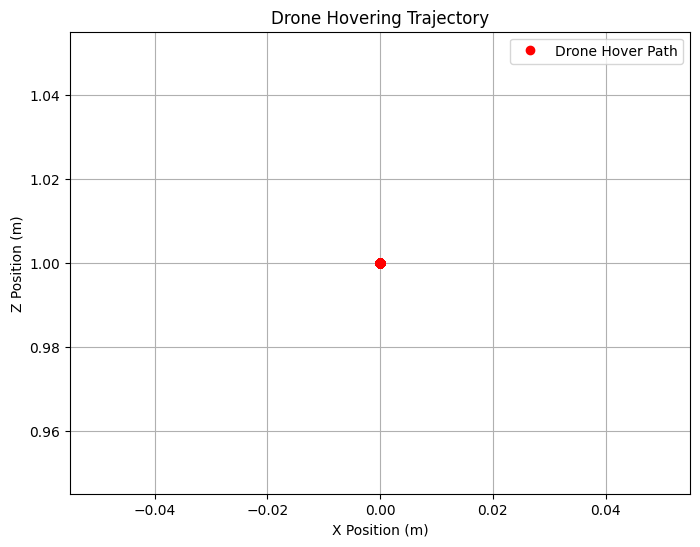

In [11]:
dt = 0.01  # Time step in seconds
simulation_time = 120  # Total simulation time in seconds
time_steps = int(simulation_time / dt)


hover_waypoints = [[0, 0, 1] for _ in range(time_steps)]
hover_controller = Controller(goal_path=hover_waypoints)

# Reset the controller and initialize the state for hovering at [0, 0, 1]
hover_controller.reset()
hover_controller.xhat[:3] = [0, 0, 1]


time_history = np.linspace(0, simulation_time, time_steps)

for t in time_history:
    inputs = hover_controller.run(dt=dt, time=t)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(hover_controller.xhat_history["px"], hover_controller.xhat_history["pz"], "ro",label="Drone Hover Path")

ax.set_title("Drone Hovering Trajectory")
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Z Position (m)")
ax.grid()
ax.legend()
plt.show()

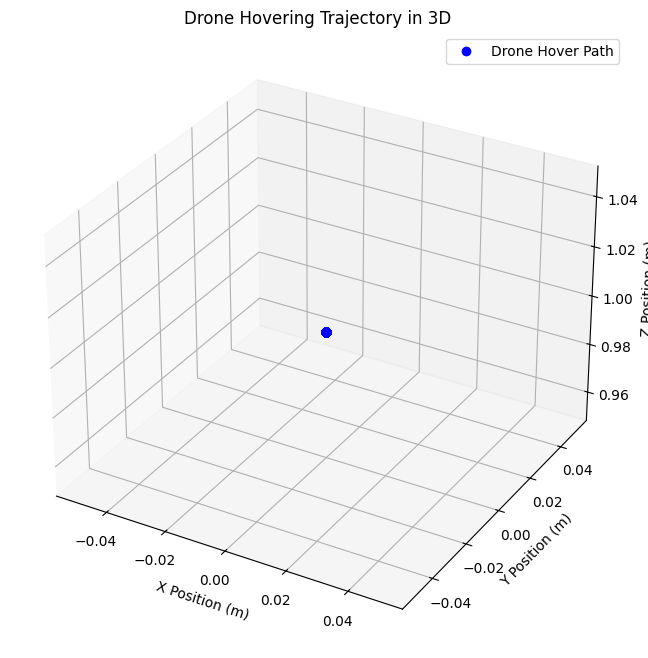

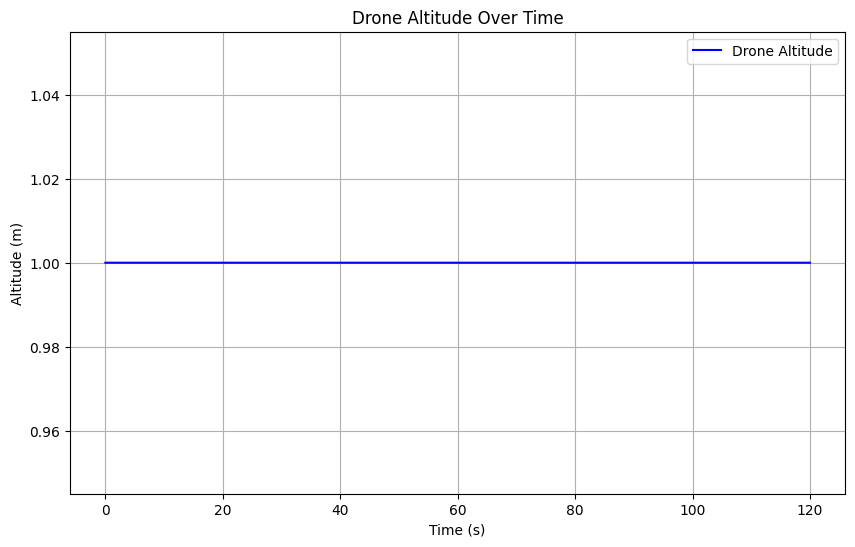

In [12]:
dt = 0.01  # Time step in seconds
simulation_time = 120  # Total simulation time in seconds
time_steps = int(simulation_time / dt)

hover_waypoints = [[0, 0, 1] for _ in range(time_steps)]


hover_controller = Controller(goal_path=hover_waypoints)
hover_controller.reset()
hover_controller.xhat[:3] = [0, 0, 1]

time_history = np.linspace(0, simulation_time, time_steps)

for t in time_history:
    inputs = hover_controller.run(dt=dt, time=t)


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(hover_controller.xhat_history["px"], hover_controller.xhat_history["py"], hover_controller.xhat_history["pz"], "bo",label="Drone Hover Path")
#ax.scatter(0, 0, 1, color='red', label="Desired Hover Point", s=100, zorder=5)
ax.set_title("Drone Hovering Trajectory in 3D")
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.set_zlabel("Z Position (m)")
ax.grid()
ax.legend()
plt.show()

time_steps = np.arange(0, len(hover_controller.xhat_history["pz"]) * 0.01, 0.01)  # Time vector
altitude = hover_controller.xhat_history["pz"]  # Altitude values

# Plot altitude over time
plt.figure(figsize=(10, 6))
plt.plot(time_steps, altitude, color="blue", label="Drone Altitude")
plt.title("Drone Altitude Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (m)")
plt.grid()
plt.legend()
plt.show()

## Performance Goal 2: Circle

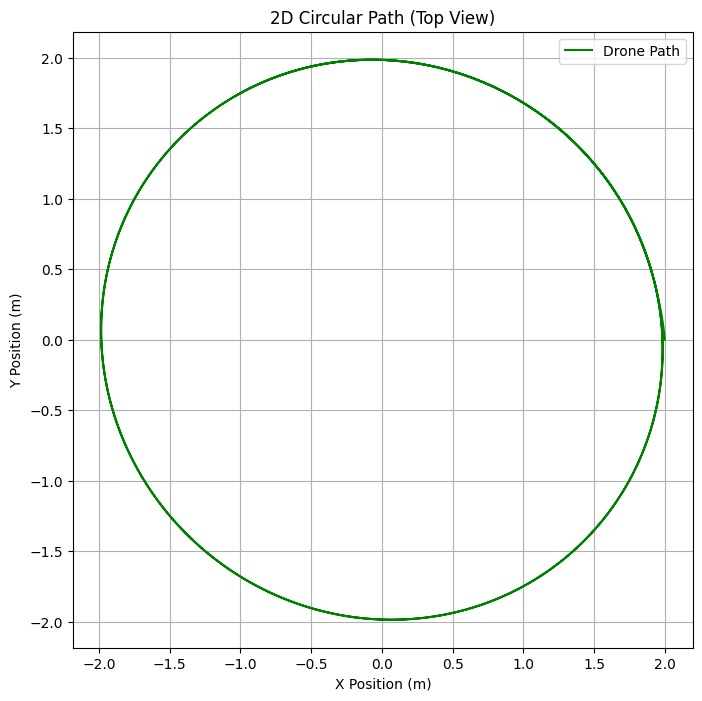

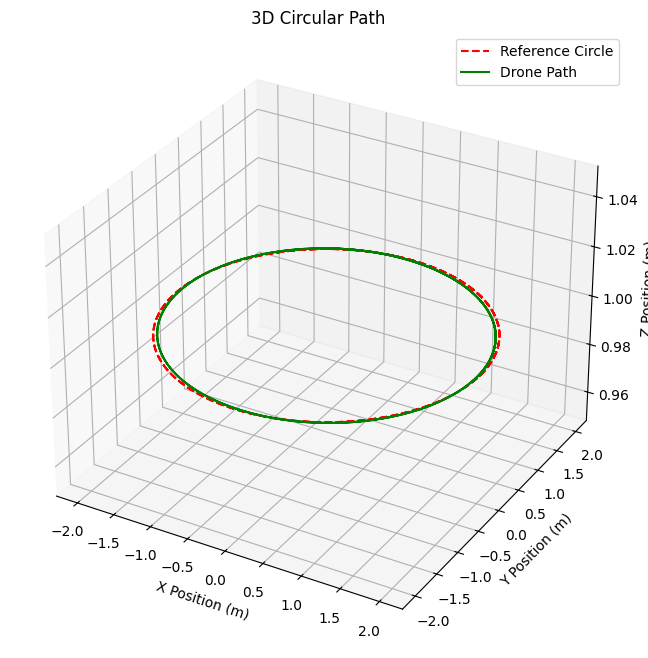

In [13]:
radius = 2
altitude = 1
speed = 0.5
duration = 60
dt = 0.01

circular_waypoints = circle_path(radius, altitude, speed, duration, dt)

# controller
circle_controller = Controller(goal_path=circular_waypoints)
circle_controller.reset()
circle_controller.xhat[:3] = circular_waypoints[0]  # Ensure the drone starts at the first waypoint


time_steps_2 = np.arange(0, duration, dt)
for t in time_steps_2:
    circle_controller.run(dt=dt, time=t)


actual_trajectory_x = circle_controller.xhat_history["px"]
actual_trajectory_y = circle_controller.xhat_history["py"]
actual_trajectory_z = circle_controller.xhat_history["pz"]

ref_x = [point[0] for point in circular_waypoints]
ref_y = [point[1] for point in circular_waypoints]
ref_z = [point[2] for point in circular_waypoints]

plt.figure(figsize=(8, 8))
plt.plot(actual_trajectory_x, actual_trajectory_y, 'g', label="Drone Path")  # Actual trajectory
plt.title("2D Circular Path (Top View)")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.axis("equal")
plt.legend()
plt.grid()
plt.show()

# Plot the 3D path
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(ref_x, ref_y, ref_z, 'r--', label="Reference Circle")  # Reference path
ax.plot(actual_trajectory_x, actual_trajectory_y, actual_trajectory_z, 'g', label="Drone Path")  # Actual path
ax.set_title("3D Circular Path")
ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.set_zlabel("Z Position (m)")
ax.legend()
plt.show()

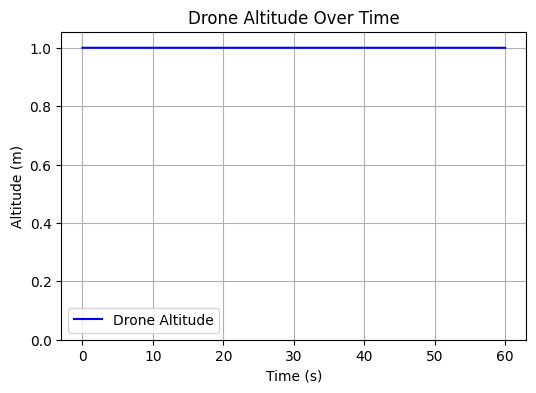

In [14]:
# Extract altitude (z-position) over time
altitude = circle_controller.xhat_history["pz"]
time_steps = np.arange(0, len(altitude) * 0.01, 0.01)  # Time vector

# Plot altitude over time
plt.figure(figsize=(6, 4))
plt.plot(time_steps, altitude, color="blue", label="Drone Altitude")
plt.title("Drone Altitude Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (m)")
plt.grid()
plt.ylim(bottom=0)
plt.legend()
plt.show()

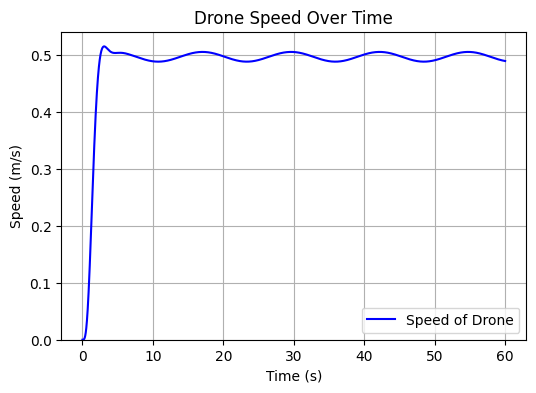

In [21]:
# Extract speed data
vx = np.array(circle_controller.xhat_history["vx"])
vy = np.array(circle_controller.xhat_history["vy"])
vz = np.array(circle_controller.xhat_history["vz"])
speed = np.sqrt(vx**2 + vy**2 + vz**2) 
time_steps = np.arange(0, len(speed)*0.01, 0.01)  # Time vector

# Plot altitude over time
plt.figure(figsize=(6, 4))
plt.plot(time_steps, speed, color="blue", label="Speed of Drone")
plt.title("Drone Speed Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.grid()
plt.ylim(bottom=0)
plt.legend()
plt.show()